In [2]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


In [3]:

# Class to store and save the model details along with evaluation metrics
class ModelObject:
    def __init__(self, model_name, model, params, best_params, evaluation_metrics, version):
        self.model_name = model_name
        self.model = model
        self.params = params
        self.best_params = best_params
        self.evaluation_metrics = evaluation_metrics
        self.version = version
    
    def log_details(self):
        log_message = f"Model: {self.model_name} (Version: {self.version})\n"
        log_message += f"Initial Parameters: {self.params}\n"
        log_message += f"Best Parameters after tuning: {self.best_params}\n"
        log_message += f"Evaluation Metrics: {self.evaluation_metrics}\n"
        return log_message

    def save(self, save_path):
        joblib.dump(self, save_path)
        print(f"Model saved at: {save_path}")

# Base Class for Dataset Handling
class Dataset:
    def __init__(self):
        self.data = None
        self.target = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self, file_path):
        # Load the dataset
        self.data = pd.read_csv(file_path)
        self.target = self.data['Calories Intake']
        self.data.drop(columns=['Calories Intake', 'User ID'], inplace=True)  # Drop target and unnecessary columns

    def preprocess(self):
        # Standardize features
        scaler = StandardScaler()
        self.data = scaler.fit_transform(self.data)
        
        # Train-test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.data, self.target, test_size=0.2, random_state=42
        )

# Base Class for Model Selection and Tuning
class ModelSelector:
    def __init__(self):
        self.models = {
            'RandomForest': RandomForestRegressor(),
            'LinearRegression': LinearRegression(),
            'GradientBoosting': GradientBoostingRegressor()
        }
        self.best_model_object = None
        self.version = 1  # Versioning starts at 1

    def hyperparameter_tuning(self, model, param_grid, X_train, y_train):
        grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        return grid_search.best_estimator_, grid_search.best_params_

    def select_model(self, X_train, y_train, X_test, y_test):
        # Define parameter grids for each model
        param_grids = {
            'RandomForest': {'n_estimators': [50, 100], 'max_depth': [5, 10]},
            'LinearRegression': {},
            'GradientBoosting': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
        }

        best_score = float('inf')
        for model_name, model in self.models.items():
            print(f"Tuning {model_name}...")
            tuned_model, best_params = self.hyperparameter_tuning(model, param_grids[model_name], X_train, y_train)
            
            # Evaluate on test data
            y_pred = tuned_model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            evaluation_metrics = {"mse": mse, "r2_score": r2}

            print(f"{model_name} Test MSE: {mse}")

            # Save model object only if it is the best one
            if mse < best_score:
                best_score = mse
                self.best_model_object = ModelObject(
                    model_name=model_name,
                    model=tuned_model,
                    params=param_grids[model_name],
                    best_params=best_params,
                    evaluation_metrics=evaluation_metrics,
                    version=self.version
                )

        print(f"Best Model: {self.best_model_object.model_name}")
        return self.best_model_object

    def save_best_model(self):
        if self.best_model_object:
            # Create the model's versioned file name
            save_path = f"{self.best_model_object.model_name}_v{self.version}.pkl"
            self.best_model_object.save(save_path)
            self.version += 1  # Increment the version for the next save

# Main AutoML Pipeline
class AutoMLPipeline:
    def __init__(self, dataset_path):
        self.dataset = Dataset()
        self.model_selector = ModelSelector()
        self.dataset_path = dataset_path

    def run(self):
        # Load and preprocess data
        print("Loading and Preprocessing Data...")
        self.dataset.load_data(self.dataset_path)
        self.dataset.preprocess()

        # Model Selection and Evaluation
        print("Selecting the best model...")
        best_model = self.model_selector.select_model(
            self.dataset.X_train, self.dataset.y_train, 
            self.dataset.X_test, self.dataset.y_test
        )

        # Save the best model with versioning
        self.model_selector.save_best_model()

# Run the AutoML pipeline
if __name__ == "__main__":
    # Replace with the actual path to your dataset
    dataset_path = r'C:\Users\User\Desktop\ca\ca-1-Health-nutrition-recommender-\nutrition\dataset.csv'
    pipeline = AutoMLPipeline(dataset_path)
    pipeline.run()

    # Load the best model for inspection
    model_file_path = 'RandomForest_v1.pkl'  # Change to the latest model file path if needed
    loaded_model_object = joblib.load(model_file_path)

    # Inspect the contents of the loaded model object
    print(f"Model Name: {loaded_model_object.model_name}")
    print(f"Version: {loaded_model_object.version}")
    print(f"Parameters: {loaded_model_object.params}")
    print(f"Best Parameters: {loaded_model_object.best_params}")
    print(f"Evaluation Metrics: {loaded_model_object.evaluation_metrics}")

    # To inspect the model itself, use the sklearn model's methods
    model = loaded_model_object.model
    print(f"Model: {model}")


Loading and Preprocessing Data...


ValueError: could not convert string to float: 'vegetarian'

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Base Class for Dataset Handling
class Dataset:
    def __init__(self):
        self.data = None
        self.target = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self, file_path):
        # Load the dataset
        self.data = pd.read_csv(file_path)
        self.target = self.data['Calories Intake']  # Assuming this is your target column
        self.data.drop(columns=['Calories Intake', 'User ID'], inplace=True)  # Drop target and unnecessary columns

    def preprocess(self):
        # Identify categorical columns (replace with your actual categorical column names)
        categorical_cols = self.data.select_dtypes(include=['object']).columns.tolist()
        numerical_cols = self.data.select_dtypes(exclude=['object']).columns.tolist()

        # Create a Column Transformer with OneHotEncoder for categorical features
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', 'passthrough', numerical_cols),  # Keep numerical columns unchanged
                ('cat', OneHotEncoder(), categorical_cols)  # One-hot encode categorical columns
            ]
        )

        # Apply the transformations
        self.data = preprocessor.fit_transform(self.data)

        # Train-test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.data, self.target, test_size=0.2, random_state=42
        )


In [5]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.pipeline import Pipeline
import numpy as np

# Class to store and save the model details along with evaluation metrics
class ModelObject:
    def __init__(self, model_name, model, params, best_params, evaluation_metrics, version):
        self.model_name = model_name
        self.model = model
        self.params = params
        self.best_params = best_params
        self.evaluation_metrics = evaluation_metrics
        self.version = version

    def log_details(self):
        log_message = f"Model: {self.model_name} (Version: {self.version})\n"
        log_message += f"Initial Parameters: {self.params}\n"
        log_message += f"Best Parameters after tuning: {self.best_params}\n"
        log_message += f"Evaluation Metrics: {self.evaluation_metrics}\n"
        return log_message

    def save(self, save_path):
        joblib.dump(self, save_path)
        print(f"Model saved at: {save_path}")

# Base Class for Dataset Handling
class Dataset:
    def __init__(self):
        self.data = None
        self.target = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self, file_path):
        # Load the dataset
        self.data = pd.read_csv(file_path)
        self.target = self.data['Calories Intake']  # Assuming this is your target column
        self.data.drop(columns=['Calories Intake', 'User ID'], inplace=True)  # Drop target and unnecessary columns

    def preprocess(self):
        # Identify categorical columns
        categorical_cols = self.data.select_dtypes(include=['object']).columns.tolist()
        numerical_cols = self.data.select_dtypes(exclude=['object']).columns.tolist()

        # Create a Column Transformer with OneHotEncoder for categorical features
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', 'passthrough', numerical_cols),  # Keep numerical columns unchanged
                ('cat', OneHotEncoder(), categorical_cols)  # One-hot encode categorical columns
            ]
        )

        # Apply the transformations
        self.data = preprocessor.fit_transform(self.data)

        # Train-test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.data, self.target, test_size=0.2, random_state=42
        )

# Base Class for Model Selection and Tuning
class ModelSelector:
    def __init__(self):
        self.models = {
            'RandomForest': RandomForestRegressor(),
        }
        self.best_model_object = None
        self.version = 1  # Versioning starts at 1

    def hyperparameter_tuning(self, model, param_grid, X_train, y_train):
        grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        return grid_search.best_estimator_, grid_search.best_params_

    def select_model(self, X_train, y_train, X_test, y_test):
        # Define parameter grids for the model
        param_grids = {
            'RandomForest': {'n_estimators': [10, 50, 100], 'max_depth': [3, 5, 7]},
        }

        best_score = float('inf')
        for model_name, model in self.models.items():
            print(f"Tuning {model_name}...")
            tuned_model, best_params = self.hyperparameter_tuning(model, param_grids[model_name], X_train, y_train)

            # Evaluate on test data
            y_pred = tuned_model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            evaluation_metrics = {"MSE": mse}

            print(f"{model_name} Test MSE: {mse}")

            # Save model object only if it is the best one
            if mse < best_score:
                best_score = mse
                self.best_model_object = ModelObject(
                    model_name=model_name,
                    model=tuned_model,
                    params=param_grids[model_name],
                    best_params=best_params,
                    evaluation_metrics=evaluation_metrics,
                    version=self.version
                )

        print(f"Best Model: {self.best_model_object.model_name}")
        return self.best_model_object

    def save_best_model(self):
        if self.best_model_object:
            # Create the model's versioned file name
            save_path = f"{self.best_model_object.model_name}_v{self.version}.pkl"
            self.best_model_object.save(save_path)
            self.version += 1  # Increment the version for the next save

# Main AutoML Pipeline
class AutoMLPipeline:
    def __init__(self, dataset_path):
        self.dataset = Dataset()
        self.model_selector = ModelSelector()
        self.dataset_path = dataset_path

    def run(self):
        # Load and preprocess data
        print("Loading and Preprocessing Data...")
        self.dataset.load_data(self.dataset_path)
        self.dataset.preprocess()

        # Model Selection and Evaluation
        print("Selecting the best model...")
        best_model = self.model_selector.select_model(
            self.dataset.X_train, self.dataset.y_train,
            self.dataset.X_test, self.dataset.y_test
        )

        # Save the best model with versioning
        self.model_selector.save_best_model()

# Run the AutoML pipeline
if __name__ == "__main__":
    # Replace with the actual path to your dataset
    dataset_path = r'C:\Users\User\Desktop\ca\ca-1-Health-nutrition-recommender-\nutrition\dataset.csv'
    pipeline = AutoMLPipeline(dataset_path)
    pipeline.run()

    # Load the best model for inspection
    model_file_path = 'RandomForest_v1.pkl'  # Change to the latest model file path if needed
    loaded_model_object = joblib.load(model_file_path)

    # Inspect the contents of the loaded


Loading and Preprocessing Data...
Selecting the best model...
Tuning RandomForest...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
RandomForest Test MSE: 184344.7705852038
Best Model: RandomForest
Model saved at: RandomForest_v1.pkl


Loading and Preprocessing Data...


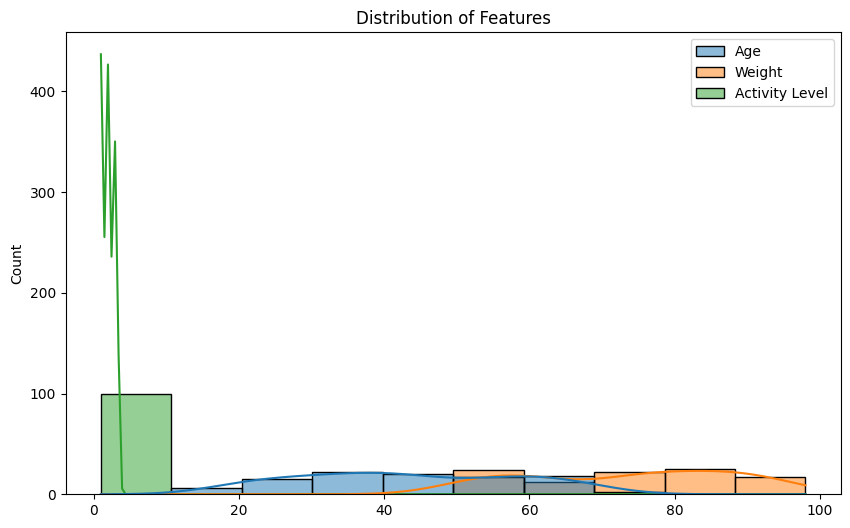

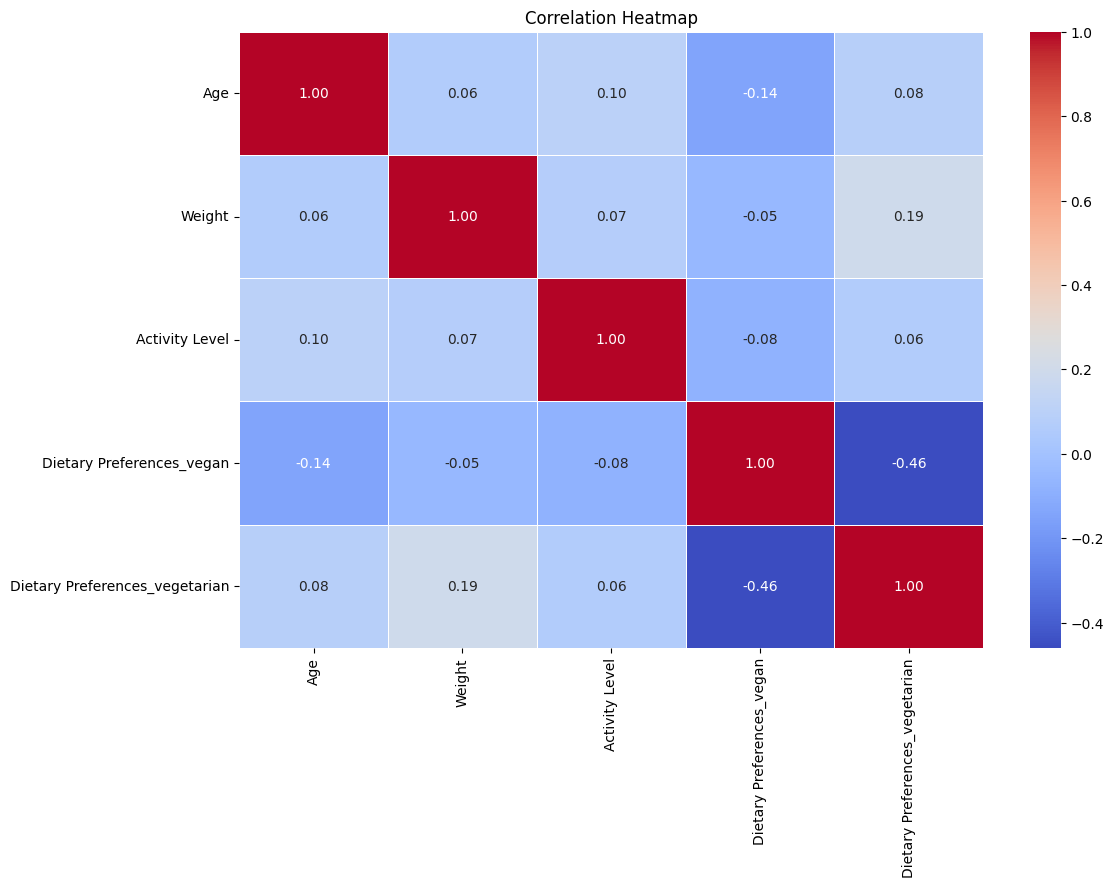

Selecting the best model...
Tuning RandomForest...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
RandomForest Test MSE: 187102.48653207356
Best Model: RandomForest
Model saved at: RandomForest_v1.pkl
Model Name: RandomForest
Version: 1
Parameters: {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15]}
Best Parameters: {'max_depth': 5, 'n_estimators': 100}
Evaluation Metrics: {'MSE': 187102.48653207356, 'R2 Score': -0.1767396661583216, 'MAE': 363.5666583946342}
Model: RandomForestRegressor(max_depth=5)


In [7]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Class to store and save the model details along with evaluation metrics
class ModelObject:
    def __init__(self, model_name, model, params, best_params, evaluation_metrics, version):
        self.model_name = model_name
        self.model = model
        self.params = params
        self.best_params = best_params
        self.evaluation_metrics = evaluation_metrics
        self.version = version

    def log_details(self):
        log_message = f"Model: {self.model_name} (Version: {self.version})\n"
        log_message += f"Initial Parameters: {self.params}\n"
        log_message += f"Best Parameters after tuning: {self.best_params}\n"
        log_message += f"Evaluation Metrics: {self.evaluation_metrics}\n"
        return log_message

    def save(self, save_path):
        joblib.dump(self, save_path)
        print(f"Model saved at: {save_path}")

# Base Class for Dataset Handling
class Dataset:
    def __init__(self):
        self.data = None
        self.target = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_data(self, file_path):
        # Load the dataset
        self.data = pd.read_csv(file_path)
        self.target = self.data['Calories Intake']  # Assuming this is your target column
        self.data.drop(columns=['Calories Intake', 'User ID'], inplace=True)  # Drop target and unnecessary columns

    def visualize_data(self):
        # Visualize data distributions
        plt.figure(figsize=(10, 6))
        sns.histplot(self.data, kde=True)
        plt.title('Distribution of Features')
        plt.show()

        # Convert categorical columns to numeric for correlation analysis
        if self.data.select_dtypes(include=['object']).shape[1] > 0:
            # Use one-hot encoding for categorical features
            data_numeric = pd.get_dummies(self.data, drop_first=True)
        else:
            data_numeric = self.data

        # Correlation heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(data_numeric.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
        plt.title('Correlation Heatmap')
        plt.show()

    def preprocess(self):
        # Identify categorical columns
        categorical_cols = self.data.select_dtypes(include=['object']).columns.tolist()
        numerical_cols = self.data.select_dtypes(exclude=['object']).columns.tolist()

        # Create a Column Transformer with OneHotEncoder for categorical features
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', 'passthrough', numerical_cols),  # Keep numerical columns unchanged
                ('cat', OneHotEncoder(), categorical_cols)  # One-hot encode categorical columns
            ]
        )

        # Apply the transformations
        self.data = preprocessor.fit_transform(self.data)

        # Train-test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.data, self.target, test_size=0.2, random_state=42
        )

# Base Class for Model Selection and Tuning
class ModelSelector:
    def __init__(self):
        self.models = {
            'RandomForest': RandomForestRegressor(),
        }
        self.best_model_object = None
        self.version = 1  # Versioning starts at 1

    def hyperparameter_tuning(self, model, param_grid, X_train, y_train):
        grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        return grid_search.best_estimator_, grid_search.best_params_

    def select_model(self, X_train, y_train, X_test, y_test):
        # Define parameter grids for each model
        param_grids = {
            'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15]},
        }

        best_score = float('inf')
        for model_name, model in self.models.items():
            print(f"Tuning {model_name}...")
            tuned_model, best_params = self.hyperparameter_tuning(model, param_grids[model_name], X_train, y_train)

            # Evaluate on test data
            y_pred = tuned_model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            evaluation_metrics = {
                "MSE": mse,
                "R2 Score": r2,
                "MAE": mae
            }

            print(f"{model_name} Test MSE: {mse}")

            # Save model object only if it is the best one
            if mse < best_score:
                best_score = mse
                self.best_model_object = ModelObject(
                    model_name=model_name,
                    model=tuned_model,
                    params=param_grids[model_name],
                    best_params=best_params,
                    evaluation_metrics=evaluation_metrics,
                    version=self.version
                )

        print(f"Best Model: {self.best_model_object.model_name}")
        return self.best_model_object

    def save_best_model(self):
        if self.best_model_object:
            # Create the model's versioned file name
            save_path = f"{self.best_model_object.model_name}_v{self.version}.pkl"
            self.best_model_object.save(save_path)
            self.version += 1  # Increment the version for the next save

# Main AutoML Pipeline
class AutoMLPipeline:
    def __init__(self, dataset_path):
        self.dataset = Dataset()
        self.model_selector = ModelSelector()
        self.dataset_path = dataset_path

    def run(self):
        # Load and preprocess data
        print("Loading and Preprocessing Data...")
        self.dataset.load_data(self.dataset_path)
        
        # Perform EDA and visualization
        self.dataset.visualize_data()
        
        self.dataset.preprocess()

        # Model Selection and Evaluation
        print("Selecting the best model...")
        best_model = self.model_selector.select_model(
            self.dataset.X_train, self.dataset.y_train, 
            self.dataset.X_test, self.dataset.y_test
        )

        # Save the best model with versioning
        self.model_selector.save_best_model()

# Run the AutoML pipeline
if __name__ == "__main__":
    dataset_path = r'C:\Users\User\Desktop\ca\ca-1-Health-nutrition-recommender-\nutrition\dataset.csv'
    pipeline = AutoMLPipeline(dataset_path)
    pipeline.run()

    # Load the best model for inspection
    model_file_path = 'RandomForest_v1.pkl'  # Change to the latest model file path if needed
    loaded_model_object = joblib.load(model_file_path)

    # Inspect the contents of the loaded model object
    print(f"Model Name: {loaded_model_object.model_name}")
    print(f"Version: {loaded_model_object.version}")
    print(f"Parameters: {loaded_model_object.params}")
    print(f"Best Parameters: {loaded_model_object.best_params}")
    print(f"Evaluation Metrics: {loaded_model_object.evaluation_metrics}")

    # To inspect the model itself, use the sklearn model's methods
    model = loaded_model_object.model
    print(f"Model: {model}")


In [9]:
import pandas as pd
import joblib
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

class ModelTester:
    def __init__(self, model_file_path, data_file_path):
        # Load the model
        self.model_object = joblib.load(model_file_path)
        self.model = self.model_object.model
        self.data_file_path = data_file_path
        self.preprocessor = None  # To hold the preprocessor

    def load_test_data(self):
        # Load the test dataset
        test_data = pd.read_csv(self.data_file_path)
        return test_data

    def preprocess_test_data(self, test_data):
        # Assume the target column is still 'Calories Intake'
        target = test_data['Calories Intake']
        test_data.drop(columns=['Calories Intake', 'User ID'], inplace=True)  # Drop unnecessary columns

        # Identify categorical columns
        categorical_cols = test_data.select_dtypes(include=['object']).columns.tolist()
        numerical_cols = test_data.select_dtypes(exclude=['object']).columns.tolist()

        # Create a Column Transformer for preprocessing
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', 'passthrough', numerical_cols),
                ('cat', OneHotEncoder(), categorical_cols)
            ]
        )

        # Transform the test data
        test_data_processed = self.preprocessor.fit_transform(test_data)
        
        return test_data_processed, target

    def test_model(self):
        # Load and preprocess test data
        test_data = self.load_test_data()
        X_test, y_test = self.preprocess_test_data(test_data)

        # Make predictions
        predictions = self.model.predict(X_test)

        # Evaluate the model
        mse = np.mean((predictions - y_test) ** 2)
        mae = np.mean(np.abs(predictions - y_test))
        r2 = 1 - (np.sum((predictions - y_test) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

        # Display evaluation metrics
        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"R2 Score: {r2}")

if __name__ == "__main__":
    # Path to the saved model file
    model_file_path = 'RandomForest_v1.pkl'  # Update as needed
    # Path to the new dataset to test
    test_data_path = r'C:\Users\User\Desktop\ca\ca-1-Health-nutrition-recommender-\nutrition\dataset.csv'

    # Create an instance of the ModelTester and test the model
    tester = ModelTester(model_file_path, test_data_path)
    tester.test_model()


Mean Squared Error (MSE): 84944.09732425913
Mean Absolute Error (MAE): 234.45907270999905
R2 Score: 0.44604374773803435
